In [3]:
# --- CHECKPOINT 1 (Imports & Paths) ---

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

BASE = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset"
ALL_DIR = os.path.join(BASE, "ALL")

TRAIN_NEW = os.path.join(BASE, "train_new")
VAL_NEW   = os.path.join(BASE, "val_new")
TEST_NEW  = os.path.join(BASE, "test_new")

print("Paths loaded successfully.")


Paths loaded successfully.


Number of class folders found: 38

Per-class counts (showing up to first 20 classes):
01. Apple___Apple_scab: 2521
02. Apple___Black_rot: 2485
03. Apple___Cedar_apple_rust: 2201
04. Apple___healthy: 2511
05. Blueberry___healthy: 2270
06. Cherry_(including_sour)___Powdery_mildew: 2104
07. Cherry_(including_sour)___healthy: 2282
08. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 2052
09. Corn_(maize)___Common_rust_: 2384
10. Corn_(maize)___Northern_Leaf_Blight: 2386
11. Corn_(maize)___healthy: 2324
12. Grape___Black_rot: 2360
13. Grape___Esca_(Black_Measles): 2400
14. Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 2152
15. Grape___healthy: 2115
16. Orange___Haunglongbing_(Citrus_greening): 2513
17. Peach___Bacterial_spot: 2297
18. Peach___healthy: 2160
19. Pepper,_bell___Bacterial_spot: 2391
20. Pepper,_bell___healthy: 2485

Total images in ALL/: 87873


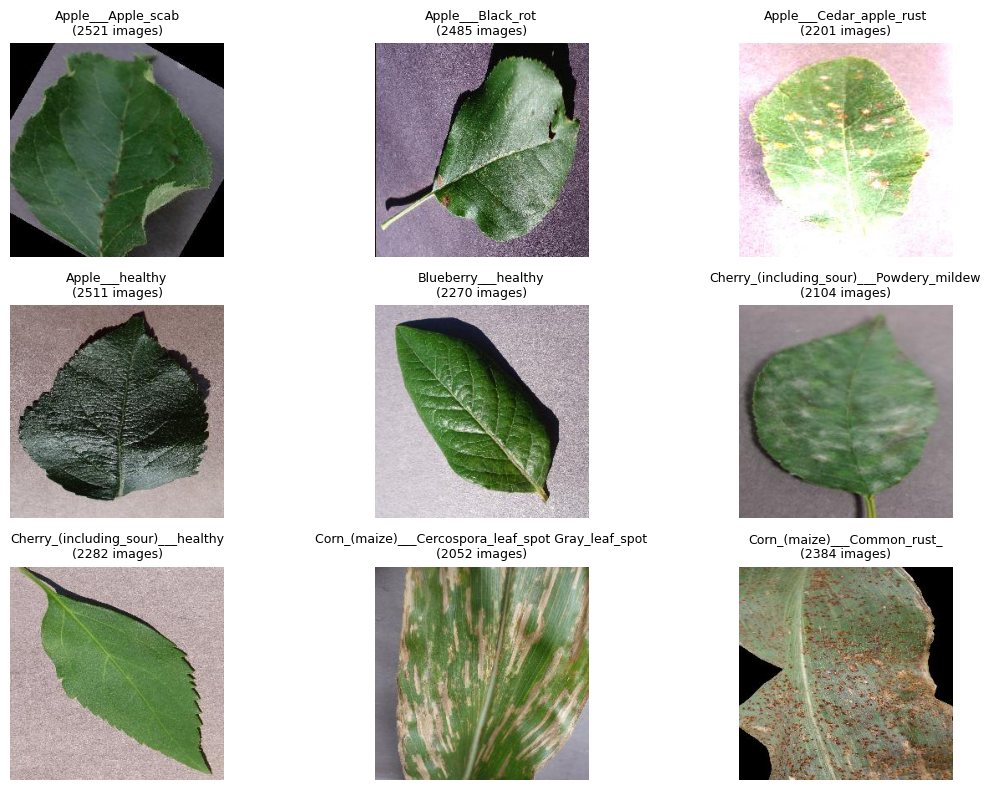

In [4]:
# --- CHECKPOINT 2 (Inspect ALL) ---

import os
from PIL import Image
import matplotlib.pyplot as plt

ALL_DIR = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/ALL"

# 1) Basic checks
if not os.path.exists(ALL_DIR):
    raise FileNotFoundError(f"ALL directory not found: {ALL_DIR}")

classes = [c for c in os.listdir(ALL_DIR) if os.path.isdir(os.path.join(ALL_DIR, c))]
classes.sort()

print(f"Number of class folders found: {len(classes)}\n")

total = 0
counts = {}
for cls in classes:
    cls_path = os.path.join(ALL_DIR, cls)
    imgs = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    counts[cls] = len(imgs)
    total += len(imgs)

# Print summary (show top 20 classes for brevity; you can expand)
print("Per-class counts (showing up to first 20 classes):")
for i, cls in enumerate(classes[:20], 1):
    print(f"{i:02d}. {cls}: {counts[cls]}")

print(f"\nTotal images in ALL/: {total}")

# 2) Display one sample per first 9 classes
n_display = min(9, len(classes))
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:n_display]):
    cls_path = os.path.join(ALL_DIR, cls)
    imgs = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    if not imgs:
        continue
    img_path = os.path.join(cls_path, imgs[0])
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")
        continue

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"{cls}\n({counts[cls]} images)", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
# --- CHECKPOINT 3 (Safe: verify/create split folders without deleting anything) ---

import os

TRAIN_NEW = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/train_new"
VAL_NEW   = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/val_new"
TEST_NEW  = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/test_new"

# Create folders if not present
for folder in [TRAIN_NEW, VAL_NEW, TEST_NEW]:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

print("\nAll split folders are ready.")


Folder already exists: /Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/train_new
Folder already exists: /Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/val_new
Folder already exists: /Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/test_new

All split folders are ready.


In [6]:
# --- CHECKPOINT 4 (Collect ALL images + Stratified 70/20/10 split) ---

from sklearn.model_selection import train_test_split
import os

ALL_DIR = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/ALL"

image_paths = []
labels = []

# Step 1 — Collect all images and labels
for class_name in os.listdir(ALL_DIR):
    class_folder = os.path.join(ALL_DIR, class_name)
    
    if not os.path.isdir(class_folder):
        continue

    for img in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img)
        if os.path.isfile(img_path):
            image_paths.append(img_path)
            labels.append(class_name)

print(f"Total images collected: {len(image_paths)}")


# Step 2 — First split (Train = 70%, Temp = 30% (Val+Test))
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.30,        # 30% → temp (val+test)
    stratify=labels,
    random_state=42
)

# Step 3 — Second split (Val = 20%, Test = 10%)
# 10/30 = 0.3333 of temp should go to test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=(10 / 30),   # = 0.3333
    stratify=temp_labels,
    random_state=42
)

print("\n--- SPLIT RESULT ---")
print(f"Train images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Test images: {len(test_paths)}")


Total images collected: 87873

--- SPLIT RESULT ---
Train images: 61511
Validation images: 17574
Test images: 8788


In [8]:
# --- CHECKPOINT 6 (Verify image counts in new splits) ---

import os

TRAIN_NEW = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/train_new"
VAL_NEW   = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/val_new"
TEST_NEW  = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/test_new"

def count_images(folder):
    total = 0
    print(f"\nCounting images in: {folder}\n")

    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path):
            continue

        count = len(os.listdir(cls_path))
        print(f"{cls}: {count}")
        total += count

    print(f"\nTotal images in {folder}: {total}")
    return total

train_total = count_images(TRAIN_NEW)
val_total = count_images(VAL_NEW)
test_total = count_images(TEST_NEW)

print("\n--- SUMMARY ---")
print(f"Train total: {train_total}")
print(f"Val total:   {val_total}")
print(f"Test total:  {test_total}")
print(f"Combined:    {train_total + val_total + test_total}")



Counting images in: /Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/train_new

Apple___Apple_scab: 1765
Apple___Black_rot: 1739
Apple___Cedar_apple_rust: 1541
Apple___healthy: 1758
Blueberry___healthy: 1589
Cherry_(including_sour)___Powdery_mildew: 1473
Cherry_(including_sour)___healthy: 1597
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1436
Corn_(maize)___Common_rust_: 1669
Corn_(maize)___Northern_Leaf_Blight: 1670
Corn_(maize)___healthy: 1627
Grape___Black_rot: 1652
Grape___Esca_(Black_Measles): 1680
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1506
Grape___healthy: 1480
Orange___Haunglongbing_(Citrus_greening): 1759
Peach___Bacterial_spot: 1608
Peach___healthy: 1512
Pepper,_bell___Bacterial_spot: 1674
Pepper,_bell___healthy: 1739
Potato___Early_blight: 1697
Potato___Late_blight: 1697
Potato___healthy: 1596
Raspberry___healthy: 1558
Soybean___healthy: 1769
Squash___Powdery_mildew: 1519
Strawberry___Leaf_scorch: 1553
Strawberry___healthy: 1596
Tomato___Bacterial_spot:

In [9]:
# --- CHECKPOINT 7 (Create TF Datasets) ---

import tensorflow as tf

IMG_SIZE = (224, 224)   # EfficientNet recommended
BATCH_SIZE = 32

train_dir = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/train_new"
val_dir   = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/val_new"
test_dir  = "/Users/aditya/Desktop/Repositories/MinorProject-1/Dataset/test_new"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\nDatasets created!")
print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))
print("Test batches:", len(test_ds))


Found 61508 files belonging to 38 classes.
Found 17571 files belonging to 38 classes.
Found 8788 files belonging to 38 classes.

Datasets created!
Train batches: 1923
Val batches: 550
Test batches: 275


In [10]:
# --- CHECKPOINT 8 (Data Augmentation + Prefetching) ---

import tensorflow as tf
from tensorflow.keras import layers

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
], name="data_augmentation")

# Apply augmentation to TRAIN only
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

# Cache + prefetch for performance
train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Augmentation + Prefetch pipeline ready!")


Augmentation + Prefetch pipeline ready!


In [11]:
# --- CHECKPOINT 9 (MobileNetV2 Pretrained, NO ERRORS) ---

import tensorflow as tf
from tensorflow.keras import layers, Model

NUM_CLASSES = 38
IMG_SIZE = (224, 224)

# Input
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))

# Pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze for initial training

# Build head
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Safe Training Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.BackupAndRestore("backup_training"),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

print("\nMobileNetV2 model & callbacks ready.")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,933,350 (11.19 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


MobileNetV2 model & callbacks ready.


In [14]:
# --- CHECKPOINT 10 (Start Training with Resume Support) ---

import time

EPOCHS = 15

print("⚠ Training will take time depending on your machine.")
print(f"Estimated: ~1–3 minutes per epoch on CPU, faster on GPU.\n")
print("⏳ Training starting in 3 seconds...")
time.sleep(3)

history = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\n🎉 Training complete!")


⚠ Training will take time depending on your machine.
Estimated: ~1–3 minutes per epoch on CPU, faster on GPU.

⏳ Training starting in 3 seconds...
Epoch 1/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 360s 186ms/step - accuracy: 0.5454 - loss: 1.5458 - val_accuracy: 0.4712 - val_loss: 1.7983
Epoch 2/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 435s 226ms/step - accuracy: 0.6796 - loss: 1.0430 - val_accuracy: 0.4905 - val_loss: 1.7877
Epoch 3/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 445s 231ms/step - accuracy: 0.7171 - loss: 0.9073 - val_accuracy: 0.5149 - val_loss: 1.7224
Epoch 4/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 453s 236ms/step - accuracy: 0.7445 - loss: 0.8164 - val_accuracy: 0.5537 - val_loss: 1.5622
Epoch 5/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 451s 235ms/step - accuracy: 0.7609 - loss: 0.7537 - val_accuracy: 0.5627 - val_loss: 1.5565
Epoch 6/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 483s 251ms/step - accuracy: 0.7767 - loss: 0.7017 - val_accuracy: 0.5638 - val_loss: 1.5790
Epoch 7/15
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 445s 23

In [15]:
model.save("stage1_mobilenet_model.keras")

In [12]:
for layer in base_model.layers[-40:]:
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
history_ft1 = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)
history_ft1 = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)



Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 522s 270ms/step - accuracy: 0.3666 - loss: 2.3487 - val_accuracy: 0.3116 - val_loss: 2.4289
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 576s 300ms/step - accuracy: 0.6368 - loss: 1.2281 - val_accuracy: 0.5493 - val_loss: 1.5096
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 600s 312ms/step - accuracy: 0.7274 - loss: 0.9027 - val_accuracy: 0.6030 - val_loss: 1.3024
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 621s 323ms/step - accuracy: 0.7821 - loss: 0.7130 - val_accuracy: 0.6220 - val_loss: 1.2477
Epoch 5/20
 727/1923 ━━━━━━━━━━━━━━━━━━━━ 5:14 263ms/step - accuracy: 0.8021 - loss: 0.6417

: 